In [77]:
!pip install opencv-python open3d numpy matplotlib

In [78]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

In [ ]:
img1 = cv2.imread("img1.png")

In [79]:
from torchvision import models
import torch

In [3]:
!git clone https://github.com/SoccerNet/sn-calibration

Cloning into 'sn-calibration'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 232 (delta 60), reused 53 (delta 48), pack-reused 150 (from 1)
Receiving objects: 100% (232/232), 2.68 MiB | 33.46 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [4]:
%cd sn-calibration

/content/sn-calibration


In [5]:
%cd src/

/content/sn-calibration/src


In [6]:
%ls

baseline_cameras.py  detect_extremities.py  evaluate_extremities.py
camera.py            evalai_camera.py       soccerpitch.py
dataloader.py        evaluate_camera.py


In [7]:
import os
print(os.listdir())

['dataloader.py', 'camera.py', 'evaluate_camera.py', 'evalai_camera.py', 'soccerpitch.py', 'evaluate_extremities.py', 'baseline_cameras.py', 'detect_extremities.py']


NOTE

download weights from https://github.com/SoccerNet/sn-calibration (do f1 "drive"to find link) and move inside resources

go into src/detect_extremities.py (double clic to open editor on colab) and remove src from "from src.soccerpitch import SoccerPitch" and save

In [11]:
from detect_extremities import SegmentationNetwork

In [12]:
seg_net = SegmentationNetwork(
    "../resources/soccer_pitch_segmentation.pth",
    "../resources/mean.npy",
    "../resources/std.npy"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


In [13]:
from soccerpitch import SoccerPitch

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
  lines_palette.extend(SoccerPitch.palette[line_class])

Move img1 to sn-calibration/images

(548, 960, 3)


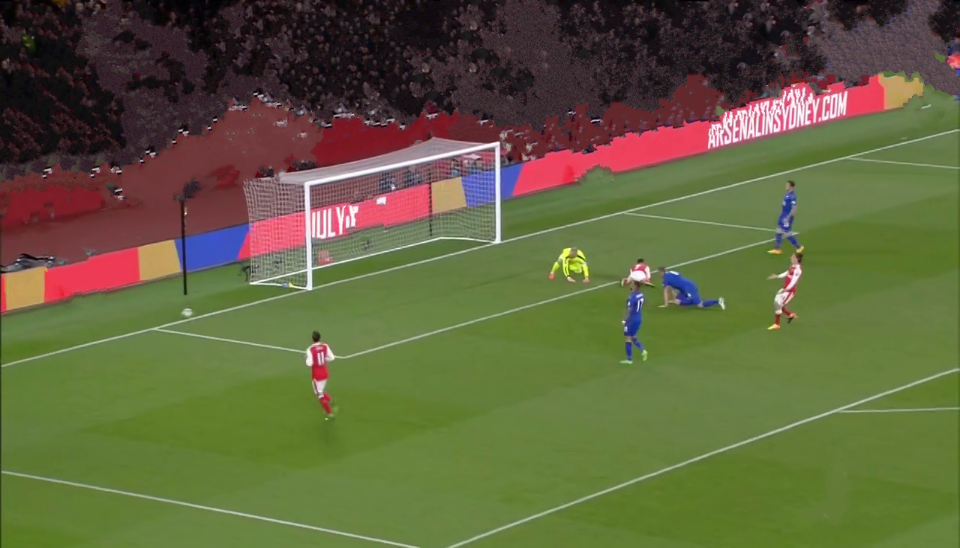

In [164]:
from PIL import Image
import cv2

image = cv2.imread("../images/img3.png")
image = cv2.resize(image, (960, 548))
print(image.shape)
rgbimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgbimage)
pil_image

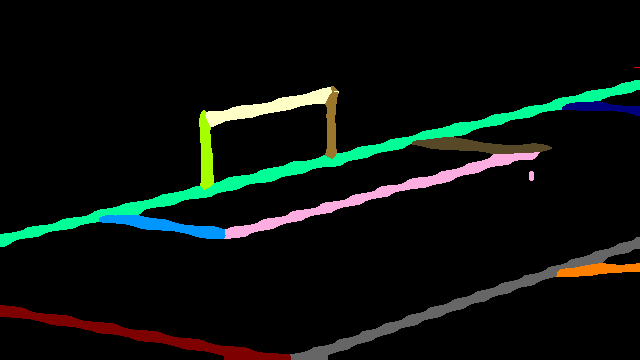

In [165]:
import numpy as np

seg_mask = seg_net.analyse_image(image)
mask = Image.fromarray(seg_mask.astype(np.uint8)).convert('P')
mask.putpalette(lines_palette)
mask

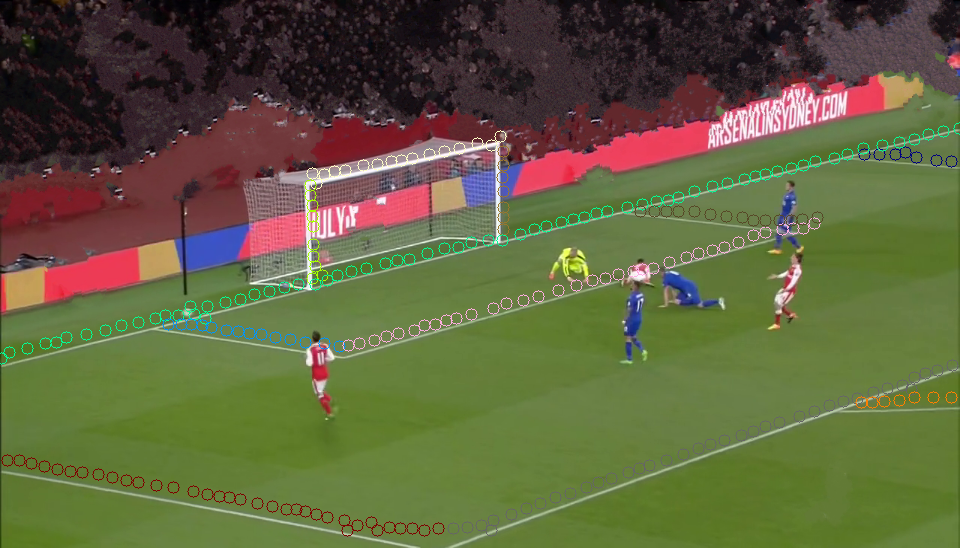

In [166]:
from detect_extremities import generate_class_synthesis, get_line_extremities

skeletons = generate_class_synthesis(seg_mask, 6)
circles_image = rgbimage.copy()
for k, circle_list in skeletons.items():
  color = SoccerPitch.palette[k]

  for circle_center in circle_list:
    cv2.circle(circles_image, (int(circle_center[1] * 548. / 360.), int(circle_center[0] * 960. / 648.)), 6, color, 1)

skeletons_image = Image.fromarray(circles_image)
skeletons_image

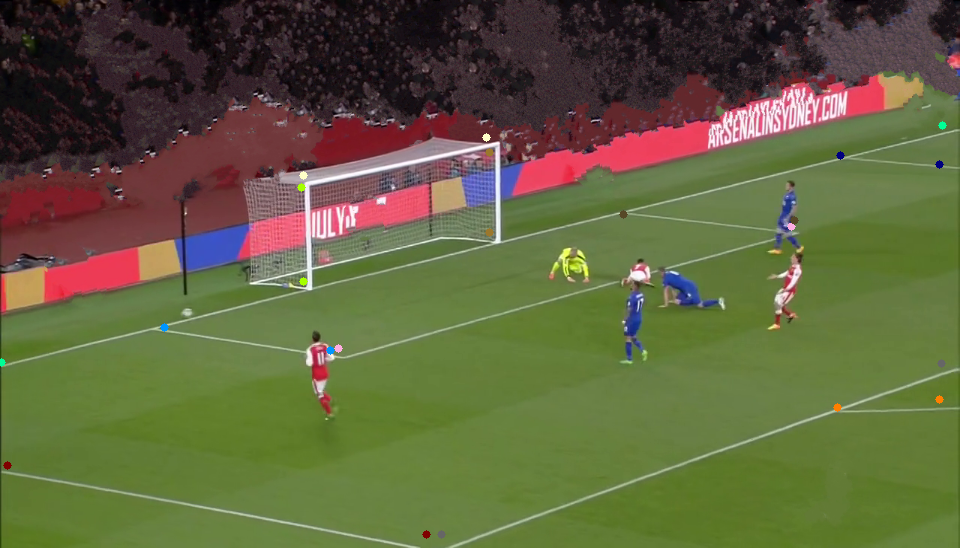

In [167]:
extremities_image = rgbimage.copy()
extremities = get_line_extremities(skeletons, 40, 648, 360)

for k, ends in extremities.items():
  color = SoccerPitch.palette[k]
  start = (int(ends[0]['x'] * 959.), int(ends[0]['y'] * 539.))
  end = (int(ends[1]['x'] * 959.), int(ends[1]['y'] * 539.))
  cv2.circle(extremities_image, start, 4, color, -1)
  cv2.circle(extremities_image, end, 4, color, -1)

extremities_pil = Image.fromarray(extremities_image)
extremities_pil

go into src/camera.py (double clic to open editor on colab) and remove src. from "from src.soccerpitch import SoccerPitch" and save

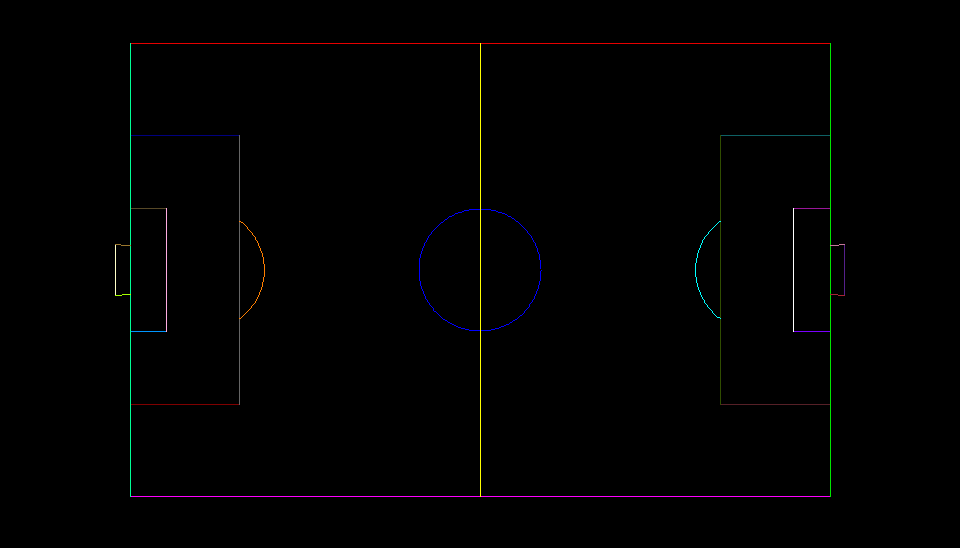

In [168]:
from camera import Camera

black_img = np.zeros((548, 960, 3), dtype=np.uint8)

camera = Camera()
camera.xfocal_length = 400
camera.yfocal_length = 400
camera.position = [0, 0, -60]
camera.draw_colorful_pitch(black_img, SoccerPitch.palette)
rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

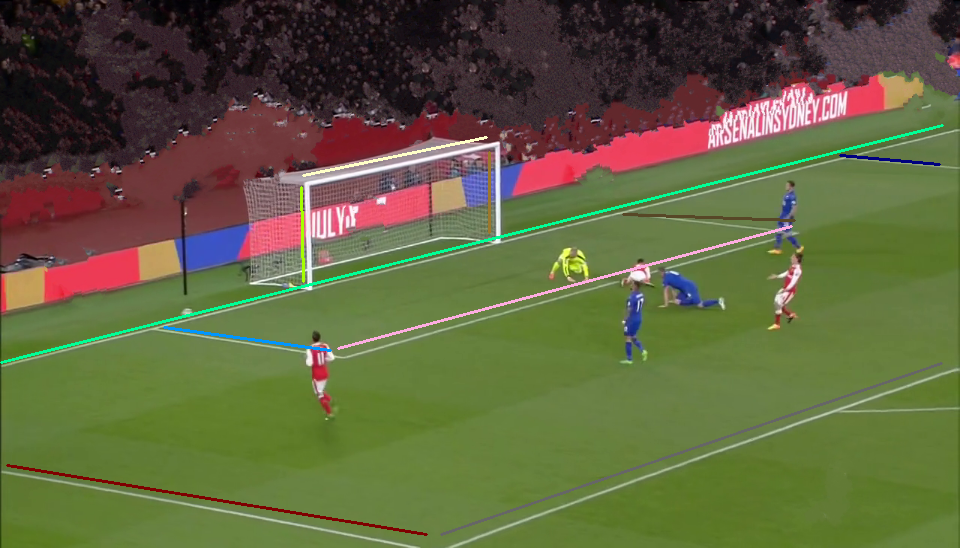

In [169]:
extremities_image = rgbimage.copy()
extremities = get_line_extremities(skeletons, 40, 648, 360)

pitch = SoccerPitch()
line_matches = []
for k, ends in extremities.items():
  if "Circle" in k:
    continue
  color = SoccerPitch.palette[k]
  start = (int(ends[0]['x'] * 959.), int(ends[0]['y'] * 539.))
  end = (int(ends[1]['x'] * 959.), int(ends[1]['y'] * 539.))
  cv2.line(extremities_image, start, end, color, 2)

  line = np.cross([start[0], start[1], 1], [end[0], end[1], 1])
  if np.isnan(np.sum(line)) or np.isinf(np.sum(line)):
    continue
  line_pitch = pitch.get_2d_homogeneous_line(k)
  if line_pitch is not None:
    line_matches.append((line_pitch, line))

extremities_pil = Image.fromarray(extremities_image)
extremities_pil

In [170]:
def estimate_homography_from_line_correspondences(lines, T1=np.eye(3), T2=np.eye(3)):
    """
    Given lines correspondences, computes the homography that maps best the two set of lines.
    :param lines: list of pair of 2D lines matches.
    :param T1: Similarity transform to normalize the elements of the source reference system
    :param T2: Similarity transform to normalize the elements of the target reference system
    :return: boolean to indicate success or failure of the estimation, homography
    """
    homography = np.eye(3)
    A = np.zeros((len(lines) * 2, 9))

    for i, line_pair in enumerate(lines):
        src_line = np.transpose(np.linalg.inv(T1)) @ line_pair[0]
        target_line = np.transpose(np.linalg.inv(T2)) @ line_pair[1]
        u = src_line[0]
        v = src_line[1]
        w = src_line[2]

        x = target_line[0]
        y = target_line[1]
        z = target_line[2]

        A[2 * i, 0] = 0
        A[2 * i, 1] = x * w
        A[2 * i, 2] = -x * v
        A[2 * i, 3] = 0
        A[2 * i, 4] = y * w
        A[2 * i, 5] = -v * y
        A[2 * i, 6] = 0
        A[2 * i, 7] = z * w
        A[2 * i, 8] = -v * z

        A[2 * i + 1, 0] = x * w
        A[2 * i + 1, 1] = 0
        A[2 * i + 1, 2] = -x * u
        A[2 * i + 1, 3] = y * w
        A[2 * i + 1, 4] = 0
        A[2 * i + 1, 5] = -u * y
        A[2 * i + 1, 6] = z * w
        A[2 * i + 1, 7] = 0
        A[2 * i + 1, 8] = -u * z

    try:
        u, s, vh = np.linalg.svd(A)
    except np.linalg.LinAlgError:
        return False, homography
    v = np.eye(3)
    has_positive_singular_value = False
    for i in range(s.shape[0] - 1, -2, -1):
        v = np.reshape(vh[i], (3, 3))

        if s[i] > 0:
            has_positive_singular_value = True
            break

    if not has_positive_singular_value:
        return False, homography

    homography = np.reshape(v, (3, 3))
    homography = np.linalg.inv(T2) @ homography @ T1
    homography /= homography[2, 2]

    return True, homography

success, homography = estimate_homography_from_line_correspondences(line_matches)
homography

array([[ 5.00475029e+01, -4.65684962e+01,  3.24455871e+03],
       [ 2.95946845e+00,  7.02143112e+00,  5.79785382e+02],
       [-1.14440517e-02, -1.29890235e-02,  1.00000000e+00]])

again remove src from the file

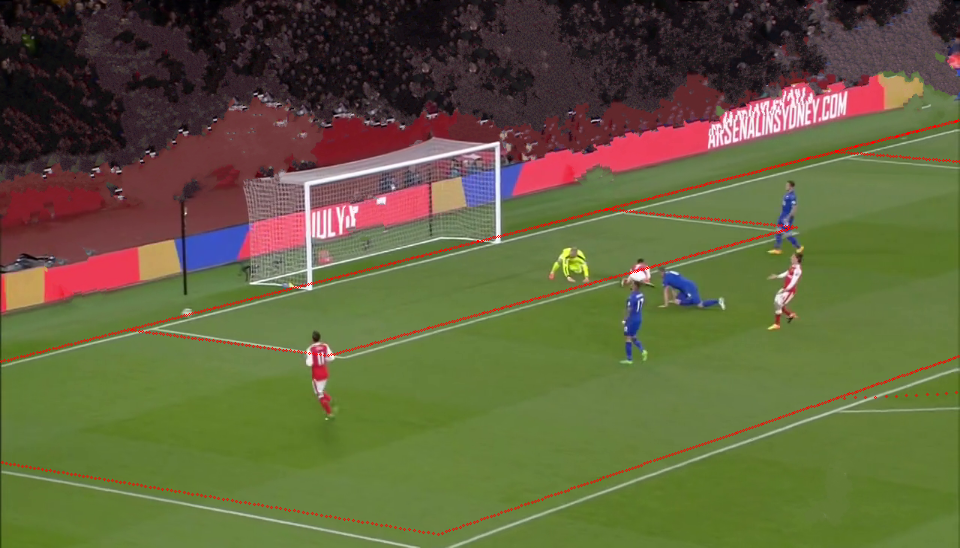

In [183]:
from baseline_cameras import draw_pitch_homography

cv_image = draw_pitch_homography(rgbimage, homography)
homography_pil = Image.fromarray(cv_image)
homography_pil


In [154]:
def from_homography(self, homography):
        """
        This method initializes the essential camera parameters from the homography between the world plane of the pitch
        and the image. It is based on the extraction of the calibration matrix from the homography (Algorithm 8.2 of
        Multiple View Geometry in computer vision, p225), then using the relation between the camera parameters and the
        same homography, we extract rough rotation and position estimates (Example 8.1 of Multiple View Geometry in
        computer vision, p196).
        :param homography: The homography that captures the transformation between the 3D flat model of the soccer pitch
         and its image.
        """
        success, _ = self.estimate_calibration_matrix_from_plane_homography(homography)
        if not success:
            return False

        hprim = np.linalg.inv(self.calibration) @ homography
        lambda1 = 1 / np.linalg.norm(hprim[:, 0])
        lambda2 = 1 / np.linalg.norm(hprim[:, 1])
        lambda3 = np.sqrt(lambda1 * lambda2)

        r0 = hprim[:, 0] * lambda1
        r1 = hprim[:, 1] * lambda2
        r2 = np.cross(r0, r1)

        R = np.column_stack((r0, r1, r2))
        u, s, vh = np.linalg.svd(R)
        R = u @ vh
        if np.linalg.det(R) < 0:
            u[:, 2] *= -1
            R = u @ vh
        self.rotation = R
        t = hprim[:, 2] * lambda3
        self.position = - np.transpose(R) @ t
        return True

cam = Camera(960, 548)
success = cam.from_homography(homography)
cam.to_json_parameters()

{'pan_degrees': np.float64(-41.5612607365056),
 'tilt_degrees': np.float64(79.963691873881),
 'roll_degrees': np.float64(3.2095068298514744),
 'position_meters': [-2.3539897740994142,
  57.67793635843232,
  -13.65026607713871],
 'x_focal_length': np.float64(3457.400980255783),
 'y_focal_length': np.float64(3457.40098025567),
 'principal_point': [480.0, 274.0],
 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tangential_distortion': [0.0, 0.0],
 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}